In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
if '..' not in sys.path:
    sys.path.append('..')
sys.path
os.chdir('c:\\Users\\Reuven\\PycharmProjects\\ProjectA')

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import argparse
from typing import Iterable, List, Tuple, Any, Dict, Union
import mediapipe as mp


Point = Tuple[int, int]
Rect = Tuple[int, int, int, int]
Image = np.ndarray

from Project_A.utils.keyboard_segmentation import KeyboardSegmentation
from Project_A.utils.hand_segmentation import HandSegmentation
from Project_A.utils.mouse_segmentation import MouseSegmentation
from Project_A.utils.keyboard_layout import Key, Keyboard_Layout


In [4]:
keyboard_segmentation = KeyboardSegmentation()
hand_segmentation = HandSegmentation()
mouse_hand_segmentation = HandSegmentation(history_size = 1)
mouse_segmentation = MouseSegmentation()
keyboard_layout = Keyboard_Layout((keyboard_segmentation.homography_width,
                                            keyboard_segmentation.homography_height))
video_file_path = ""

In [5]:
# cap = cv2.VideoCapture(video_file_path)
# cap = cv2.VideoCapture(0)
# success = True
# while success:
#     success, image = cap.read()
#     if cap is None or not cap.isOpened() or not success:
#         raise IndexError(f'Unable to open video source')
#     keyboard_segmentation.segment_keyboard(image)
#     hand_segmentation.segment_hands(image,debug=False)
#     cv2.imshow("camera image", image)
#     keyboard_image = keyboard_segmentation.keyboard_image
#     if keyboard_image is not None:
#         cv2.imshow("Keyboard", keyboard_image)
#     if hand_segmentation.identify_keyboard_click():
#         try:
#             index_finger = keyboard_segmentation.project_point(hand_segmentation.index_finger)
#             if index_finger != keyboard_segmentation.NO_POINT:        
#                 key = keyboard_layout.get_key_by_index(*index_finger)
#                 print(key.key_name)
#         except Exception as e:
#             pass


In [6]:
image.shape

NameError: name 'image' is not defined

In [ ]:
image_folder = r'C:\Users\Reuven\PycharmProjects\ProjectA\papertest'
images = sorted(glob.glob(f"{image_folder}/*.png"))
for image_path in images:
    image = cv2.imread(image_path)
    keyboard_segmentation.segment_keyboard(image)
    keyboard_image = keyboard_segmentation._project_keyboard_image(image, keyboard_segmentation.homography_matrix)
    if keyboard_segmentation.keyboard_image is None:
        print(image_path)


similarity=np.float64(0.3447010480726422)
similarity=np.float64(0.3702558232589069)
similarity=np.float64(0.11509761980742877)
similarity=np.float64(0.3438935260683911)
similarity=np.float64(0.34773424645422907)
similarity=np.float64(0.11607548367944415)
similarity=np.float64(0.3390546277722162)


[[141.0, 164.0], [498.0, 188.0], [527.0, 356.0], [87.0, 329.0]]


[]

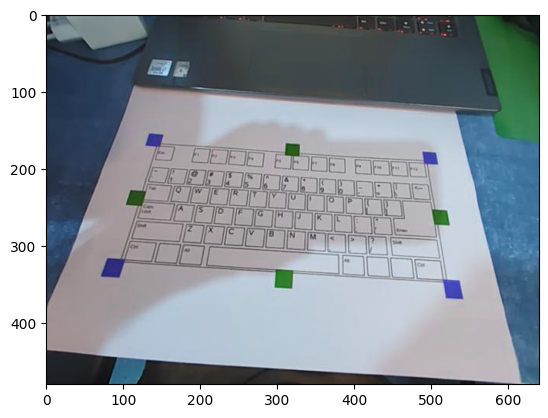

In [13]:
image_path = r'C:\Users\Reuven\PycharmProjects\ProjectA\papertest\frame_0160.png'
# image_path = r'C:\Users\Reuven\PycharmProjects\ProjectA\papertest\frame_0088.png'
image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
keyboard_segmentation.segment_keyboard(image)
keyboard_segmentation.green_coordinates
# keyboard_image = keyboard_segmentation._project_keyboard_image(image, keyboard_segmentation.homography_matrix)

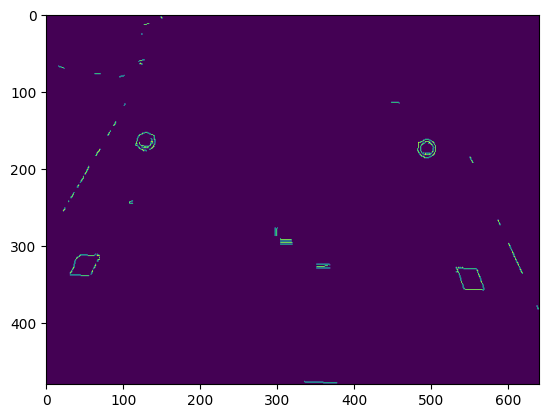

In [11]:
color = 'red'
original = image.copy()
# Step 1: Increase contrast using CLAHE on the V channel
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(10, 10))
v = clahe.apply(v)
hsv = cv2.merge((h, s, v))
# hsv = cv2.GaussianBlur(hsv, (5, 5), 0)

# Red color mask with robust thresholds
if color == 'red':
    lower_red1 = np.array([0, 40, 40])
    upper_red1 = np.array([12, 255, 255])
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)

    lower_red2 = np.array([170, 40, 40])
    upper_red2 = np.array([180, 255, 255])
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    # mask = mask1
    mask = mask1 + mask2
elif color == 'green':
    lower_green = np.array([35,40,40])
    upper_green = np.array([85,255,255])

    mask = cv2.inRange(hsv, lower_green, upper_green)
else:
    raise TypeError(f"Color {color} is invalid")

kernel = np.ones((3, 3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel, iterations=1)

# Step 4: Canny edge detection to find shapes
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150)

# Combine red mask and edges (bitwise AND)
mask = cv2.bitwise_and(mask, edges)


contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
objects = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if 10 < w < 40 and 10 < h < 40:  # Filtering based on expected small size
        objects.append((x, y, w, h))
objects = sorted(
    objects, key=lambda x: (x[1], x[0])
)  # Sort by y, then by x
objects

plt.imshow(mask)
plt.show()

In [9]:
def is_white(pixel, threshold=80):
    # pixel: (B, G, R)
    return pixel[0] > threshold and pixel[1] > threshold and pixel[2] > threshold

def has_white_border(image, x, y, w, h, margin=20, white_thresh=0.6):
    h_img, w_img, _ = image.shape
    # Coordinates with margin (clamped to image bounds)
    x1 = max(x - margin, 0)
    y1 = max(y - margin, 0)
    x2 = min(x + w + margin, w_img)
    y2 = min(y + h + margin, h_img)

    # Create a mask for just the border area
    mask = np.zeros((y2 - y1, x2 - x1), dtype=np.uint8)
    mask[:margin, :] = 1     # top
    mask[-margin:, :] = 1    # bottom
    mask[:, :margin] = 1     # left
    mask[:, -margin:] = 1    # right

    border_region = image[y1:y2, x1:x2]
    white_pixels = 0
    total = np.count_nonzero(mask)

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j] == 1 and is_white(border_region[i, j]):
                white_pixels += 1
    print(white_pixels / total)
    return (white_pixels / total) >= white_thresh

def mean_pixels(image, x, y, w, h):
    h_img, w_img, _ = image.shape
    x1 = max(x, 0)
    y1 = max(y, 0)
    x2 = min(x + w, w_img)
    y2 = min(y + h, h_img)
    border_region = image[y1:y2, x1:x2]
    return cv2.mean(border_region)



0.971978021978022
has_white=True (116, 153, 26, 25) mean_pixels(image, x, y, w, h)=(54.716923076923074, 60.40769230769231, 163.52, 0.0)
0.9045774647887324
has_white=True (121, 161, 18, 13) mean_pixels(image, x, y, w, h)=(41.92307692307693, 43.17094017094018, 142.51709401709402, 0.0)
1.0
has_white=True (482, 162, 24, 25) mean_pixels(image, x, y, w, h)=(87.73166666666667, 93.51166666666667, 220.07000000000002, 0.0)
0.974
has_white=True (31, 311, 34, 26) mean_pixels(image, x, y, w, h)=(66.9027149321267, 66.48642533936652, 161.5712669683258, 0.0)
1.0
has_white=True (532, 328, 37, 31) mean_pixels(image, x, y, w, h)=(96.19093286835222, 93.11944202266783, 182.2205754141238, 0.0)


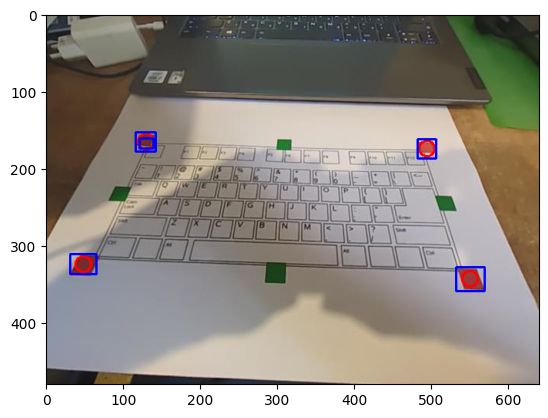

In [10]:
annotated_image = image.copy()
annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
for (x, y, w, h) in objects:
    has_white = has_white_border(image, x, y, w, h)
    if has_white:
        rgb_color = (0, 0, 255)
        print(f"{has_white=} {x, y, w, h} {mean_pixels(image, x, y, w, h)=}")
    else:
        rgb_color = (255, 0, 0)
    cv2.rectangle(annotated_image, (x, y), (x + w, y + h), rgb_color, 2)  # Red outline, thickness 2
plt.imshow(annotated_image)
plt.show()

similarity=np.float64(0.09658626390381239)
keyboard_segmentation._is_keyboard_image(keyboard_image)=False


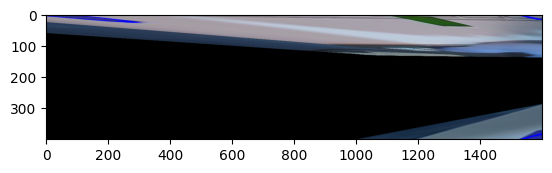

In [88]:
src_points, dst_points = keyboard_segmentation.get_matching_points(image, how='red')
keyboard_segmentation.homography_matrix = keyboard_segmentation._compute_homography(src_points, dst_points)
keyboard_image = keyboard_segmentation._project_keyboard_image(image, keyboard_segmentation.homography_matrix)
print(f"{keyboard_segmentation._is_keyboard_image(keyboard_image)=}")
plt.imshow(keyboard_image)

Circle centered at (142, 163) with radius 5
Circle centered at (397, 189) with radius 5
Circle centered at (544, 357) with radius 5
Circle centered at (799, 383) with radius 5


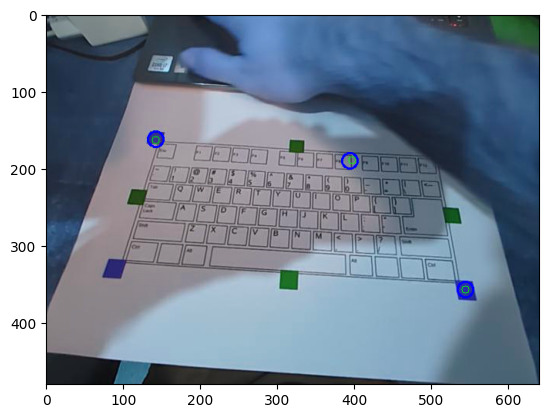

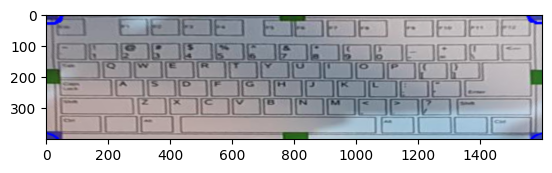

In [91]:
# Iterate over each coordinate and draw a circle around it
image_annotated = image.copy()
for coord in keyboard_segmentation.red_coordinates:
    x, y = coord
    radius = 5
    
    # Draw circle around the point
    cv2.circle(image_annotated, (x, y), radius, (0, 255, 0), 1)  # green color
    
    # Print the coordinate points for reference
    print(f"Circle centered at ({x}, {y}) with radius {radius}")
plt.imshow(image_annotated)
plt.show()
plt.imshow(keyboard_segmentation._keyboard_image_internal)
plt.show()
keyboard_image_internal = keyboard_segmentation._keyboard_image_internal.copy()
# keyboard_image_internal = keyboard_image.copy()

similarity=np.float64(0.7738365798790499)


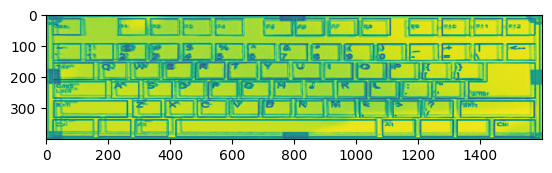

: 

In [ ]:
from skimage.metrics import structural_similarity as ssim
layout_keyboard_image_gray = cv2.imread('Project_A/keyboard_map.jpg', cv2.IMREAD_GRAYSCALE)
        # layout_keyboard_image_gray = cv2.rotate(layout_keyboard_image_gray, cv2.ROTATE_180)
cam_keyboard_image_gray = cv2.cvtColor(keyboard_image_internal, cv2.COLOR_BGR2GRAY)
layout_keyboard_image_gray = cv2.resize(layout_keyboard_image_gray,
                                        (cam_keyboard_image_gray.shape[1], cam_keyboard_image_gray.shape[0]))
similarity, S = ssim(layout_keyboard_image_gray, cam_keyboard_image_gray, gaussian_weights=True, sigma=0.3, full=True)
print(f"{similarity=}")
plt.imshow(S)
plt.show()

In [23]:
finger_point = (600, 420)
projected_point = keyboard_segmentation.project_point(finger_point)
print(f"{projected_point=}")
image_annotated = image.copy()
keyboard_image_annotated = keyboard_image.copy()

radius = 5
thickness = 3
color = (0, 0, 255)  # Red
cv2.circle(image_annotated, finger_point, radius, color, thickness)
cv2.circle(keyboard_image_annotated, projected_point, radius, color, thickness)
position = (10, 60)  # Top-left corner (x, y)
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 3
color = (255, 0, 0)  # Red color in BGR
thickness = 2

keyboard_layout_obj = Keyboard_Layout((keyboard_segmentation.homography_width,
                                            keyboard_segmentation.homography_height))
key = keyboard_layout_obj.get_key_by_index(*projected_point)
key.key_name

# Add text on top-left corner of the image
keyboard_image_annotated = cv2.putText(keyboard_image_annotated, key.key_name, position, font, font_scale, color, thickness)

plt.imshow(image_annotated)
plt.show()
plt.imshow(keyboard_image_annotated)
key.key_name

projected_point=(-1, -1)


AttributeError: 'NoneType' object has no attribute 'key_name'

In [24]:
keyboard_segmentation.homography_height

400

In [ ]:
gray_image = cv2.cvtColor(keyboard_image, cv2.COLOR_BGR2GRAY)
white_intensity = float(np.sum(gray_image) / (255.0 * gray_image.size))
white_intensity

0.6078303799019608

In [ ]:
plt.imshow(gray_image, cmap='gray')